# Starting Off

Sometimes when trying to classify problems like fraud detection, the dataset will have a lot of non-fraud cases and realtively few fraud cases.  How could a class imbalance cause a problem with your model. 

*use the term bias in your answer*

# Random Forest Practicum with Class Imbalance

Agenda:
- Review class imbalance
- Review code for different ways to handle class imbalance
- Review code for Random Forest with gridsearch
- Practice both class imbalance and Random Forest on credit data.

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics

In [2]:
# Read in data and split data to be used in the models
titanic = pd.read_csv('cleaned_titanic.csv', index_col='PassengerId')



In [3]:
# Create matrix of features
X = titanic.drop('Survived', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = titanic['Survived'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

# Handling Class Imbalance

## Visualizing Class Imbalance

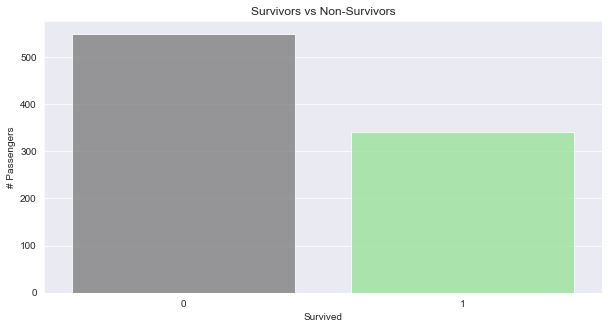

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(y, alpha =.80, palette= ['grey','lightgreen'])
plt.title('Survivors vs Non-Survivors')
plt.ylabel('# Passengers')
plt.show()

## Run a Dummy Classifier for Baseline Assessment

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)


# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, dummy_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, dummy_pred))


Test Accuracy score:  0.6412556053811659
Test F1 score:  0.0


/Users/swilson5/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Run a classification Model with class imbalance

Below you will see there is code for both a Decision Tree classifier and Logistic classifier. Currently the decision tree code is commented out. There is no reason for both of these other than I was comparing the two.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# dt_clf = DecisionTreeClassifier(max_depth=5)
lr_clf = LogisticRegression(solver='liblinear')

# dt_clf.fit(X_train, y_train)
lr_clf.fit(X_train, y_train)

# y_pred_test = dt_clf.predict(X_test)
y_pred_test = lr_clf.predict(X_test)




# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_test))

Test Accuracy score:  0.820627802690583
Test F1 score:  0.7402597402597403


## Prepping data for handling class imbalances

We are goign to change the training dataset to which we fit our model, so we want to bring our training data back together before we make those changes. 

In [7]:
# concatenate our training data back together
training  = pd.concat([X_train, y_train], axis=1)

In [8]:
# separate minority and majority classes
deceased = training[training.Survived==0]
survived = training[training.Survived==1]

In [12]:
print('deceased count: '+ str(len(deceased)))
print('survived count: '+ str(len(survived)))

deceased count: 406
survived count: 260


In [14]:
from sklearn.utils import resample


![alt text](images/resampling.png)

## Upsampling

In [ ]:

# upsample minority
survived_upsampled = resample(survived,
                          replace=True, # sample with replacement
                          n_samples=len(deceased), # match number in majority class
                          random_state=23) # reproducible results

In [ ]:
# combine majority and upsampled minority
upsampled = pd.concat([deceased, survived_upsampled])

# check new class counts
upsampled.Survived.value_counts()

In [ ]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.Survived
X_train = upsampled.drop('Survived', axis=1)


# upsampled_dt = DecisionTreeClassifier(max_depth=5)
upsampled_lr = LogisticRegression(solver='liblinear')


# upsampled_dt.fit(X_train, y_train)
upsampled_lr.fit(X_train, y_train)


# upsampled_pred = upsampled_dt.predict(X_test)
upsampled_pred = upsampled_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, upsampled_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, upsampled_pred))



## Downsampling

In [15]:

# downsample majority
survived_downsampled = resample(deceased,
                                replace = False, # sample without replacement
                                n_samples = len(survived), # match minority n
                                random_state = 23) # reproducible results




In [21]:
# combine minority and downsampled majority
downsampled = pd.concat([survived_downsampled, survived])

# checking counts
downsampled.Survived.value_counts()

1    260
0    260
Name: Survived, dtype: int64

In [23]:
# trying logistic regression again with the balanced dataset
y_train = downsampled.Survived
X_train = downsampled.drop('Survived', axis=1)


# downsampled_dt = DecisionTreeClassifier(max_depth=5)
downsampled_lr = LogisticRegression(solver='liblinear')


# downsampled_dt.fit(X_train, y_train)
downsampled_lr.fit(X_train, y_train)


# downsampled_pred = upsampled_dt.predict(X_test)
downsampled_pred = downsampled_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, downsampled_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, downsampled_pred))

Test Accuracy score:  0.7937219730941704
Test F1 score:  0.7228915662650603


## Over-sampling: SMOTE

SMOTE (Synthetic Minority Oversampling Technique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

![alt text](images/smote.png)

In [24]:
from imblearn.over_sampling import SMOTE

In [25]:

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

sm = SMOTE(random_state=23, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [26]:
# smote_dt = DecisionTreeClassifier(max_depth=5)
smote_lr = LogisticRegression(solver='liblinear')


# smote_dt.fit(X_train, y_train)
smote_lr.fit(X_train, y_train)


# smote_pred = smote_dt.predict(X_test)
smote_pred = smote_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, smote_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, smote_pred))

Test Accuracy score:  0.7847533632286996
Test F1 score:  0.68


# Fitting a Random Forest Classifier

In [48]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 23, n_estimators=100, max_depth=8)

In [49]:
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [50]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [51]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [52]:

rfc_pred = rfc.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, rfc_pred))

Test Accuracy score:  0.7982062780269058
Test F1 score:  0.6853146853146853


In [59]:
param_grid = { 
    'n_estimators': [200,300,400],
    'max_features': [0.25, 0.33, 0.5 ],
    'max_depth' : [5,6,7,8,9],
    'min_samples_leaf': [0.03,0.04,0.05,0.06]
}

In [55]:
from sklearn.model_selection import GridSearchCV


In [60]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,n_jobs=-1)
CV_rfc.fit(X_train, y_train)

/Users/swilson5/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 300, 400], 'max_features': [0.25, 0.33, 0.5], 'max_depth': [5, 6, 7, 8, 9], 'min_samples_leaf': [0.03, 0.04, 0.05, 0.06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [61]:
CV_rfc.best_params_


{'max_depth': 5,
 'max_features': 0.5,
 'min_samples_leaf': 0.03,
 'n_estimators': 300}

In [62]:
rfc_pred = CV_rfc.best_estimator_.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, rfc_pred))

Test Accuracy score:  0.7982062780269058
Test F1 score:  0.6808510638297872
